# Plots and mathematical analysis

We download the prices of a pair of crypto currencies (in this example ETH vs. BTC, prices are taken from Poloniex) and make some plots: 

*   average prices,
*   high - low,
*   logarithmic returns ("log returns"),
*  histogram of the log returns.

We then analyze the distribution of the log returns. 
(A part of this code is taken from http://www.aizac.info/simple-check-of-a-sample-against-80-distributions/)

The result of the ETH vs. BTC prices for the period 01 2019 - 05 2019: 
The power transformed positive (or negative) log returns follow a genlogistic distribution (second best fit: johnsonsu distribution).



First, we download the data. You can adjust the parameters 'currency', 'start_data_date', and  'end_data_date'. 

The  interval of time is set to 300 seconds, which is the minimal interval for data from Poloniex.

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  9 17:55:51 2019

Some plots for historical prices.

Parameters: 
    currency: poloniex currency code for the traded altcoin, XRP, ETH, SC, ...
    start_data_date: start date of the price analysis
    end_data_date: start date of the price analysis

@author: @author: Sammy-Jankins
"""

import numpy as np
import pandas as pd
import pickle
from datetime import datetime
from datetime import timedelta  
import matplotlib.pyplot as plt
import scipy.stats as stats


### Parameters
currency = 'ETH' # poloniex currency code for the traded altcoin, XRP, ETH, SC, ...
poloniex_pair = 'BTC_' + currency
start_data_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
end_data_date =  datetime.strptime('2019-05-01', '%Y-%m-%d') #datetime.now() 
###


### Load historical data from cache or from poloniex.com
try:        
    f = open('./historical_' + poloniex_pair + '_prices', 'rb')
    data_history = pickle.load(f) 
    f.close()
    print('Loaded historical ' + poloniex_pair + ' prices from cache.')
except (OSError, IOError) as e:
    print('Downloading historical '  + poloniex_pair + ' prices.') 
    base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
    start_date = start_data_date
    end_date =  start_date + timedelta(days=70)
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), 300) 
    data_df = pd.read_json(json_url)
    data_df = data_df.set_index('date')
    data_df.replace(0, np.nan, inplace=True)
    data_history = data_df.copy()
    now = end_data_date  #datetime.now() 
    
    # It seems that there is an upper limt for request sizes.
    # So we make many small requests (70 days only) and append the data.
    while end_date < now: 
        start_date = end_date
        end_date =  end_date + timedelta(days=70)
        
        # possible values for time periods (in seconds):  300, 900, 1800, 7200, 14400, and 86400.
        json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), 300)
        data_df = pd.read_json(json_url)
        data_df = data_df.set_index('date')
        data_df.replace(0, np.nan, inplace=True)
        data_history = data_history.combine_first(data_df)
        print(start_date)
        
    data_history.to_pickle('./historical_' + poloniex_pair + '_prices')
    print('Cached historical '  + poloniex_pair + ' data' + ' at {}'.format('./historical_' + poloniex_pair + '_prices'))

  
    
# We now extract the prices for the period [start_trading_date, end_trading_date]. Missing values are replaced by the last known price.
trading_dates = []
date = start_data_date
while date < end_data_date:
    trading_dates.append(date)
    date = date + timedelta(seconds=300)
        
average_prices = []
high_prices = []
low_prices = []


date = start_data_date
last_valid_price = data_history['weightedAverage'].get(date)
if last_valid_price == None:
    raise ValueError('No valid first average price for ' + currency + ' prices.')

while date < end_data_date:
    new_price = data_history['weightedAverage'].get(date)
    if new_price == None:
        average_prices.append(last_valid_price)
    else:
        average_prices.append(new_price)
        last_valid_price = new_price
    date = date + timedelta(seconds=300)

date = start_data_date
last_valid_high = data_history['high'].get(date)
if last_valid_high == None:
    raise ValueError('No valid first high price for ' + currency + ' prices.')
while date < end_data_date:
    new_high = data_history['high'].get(date)
    if new_high == None:
        high_prices.append(last_valid_high)
    else:
        high_prices.append(new_high)
        last_valid_high = new_high
    date = date + timedelta(seconds=300)
        
date = start_data_date
last_valid_low = data_history['low'].get(date)
if last_valid_low == None:
    raise ValueError('No valid first low price for ' + currency + ' prices.')
while date < end_data_date:
    new_low = data_history['low'].get(date)
    if new_low == None:
        low_prices.append(last_valid_low)
    else:
        low_prices.append(new_low)
        last_valid_low = new_low
    date = date + timedelta(seconds=300)

average_prices = np.array(average_prices)
high_prices = np.array(high_prices)
low_prices = np.array(low_prices)

2019-03-12 00:00:00
Cached historical BTC_ETH data at ./historical_BTC_ETH_prices


#Plots of the prices

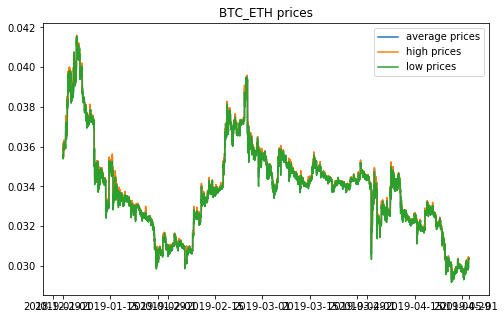

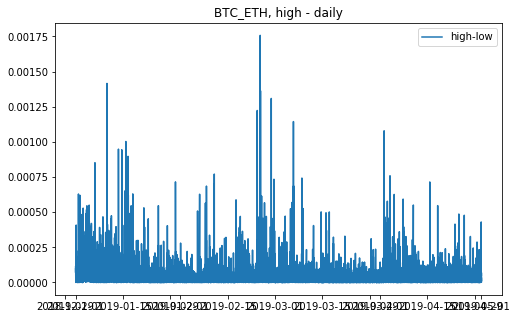

In [ ]:

### Make some plots of the prices
plt.plot(trading_dates, average_prices, label='average prices')
plt.plot(trading_dates, high_prices, label='high prices')
plt.plot(trading_dates, low_prices, label='low prices')
plt.legend()
plt.title(poloniex_pair + ' prices')
#ax=plt.axes()
#ax.xaxis.set_ticks([df.index.strftime("%d/%m/%Y%H-%M")[0], df.index.strftime("%d/%m/%Y%H-%M")[len(df.index)-1]])
#ax.xaxis.set_ticklabels([df.index.strftime("%d/%m/%Y%H-%M")[0], df.index.strftime("%d/%m/%Y%H-%M")[len(df.index)-1]])
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()


plt.plot(trading_dates, high_prices-low_prices, label='high-low')
plt.legend()
plt.title(poloniex_pair + ', high - daily')
#ax=plt.axes()
#ax.xaxis.set_ticks([df.index.strftime("%d/%m/%Y%H-%M")[0], df.index.strftime("%d/%m/%Y%H-%M")[len(df.index)-1]])
#ax.xaxis.set_ticklabels([df.index.strftime("%d/%m/%Y%H-%M")[0], df.index.strftime("%d/%m/%Y%H-%M")[len(df.index)-1]])
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()

Now we compute the log returns and plot them with respect to time and as a histogram.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


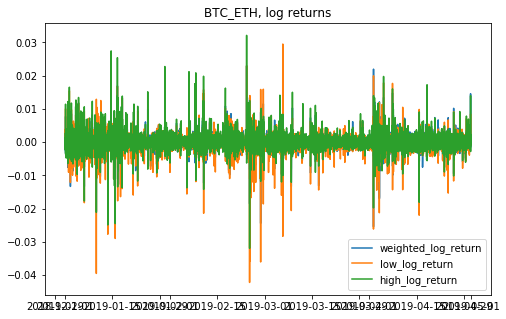

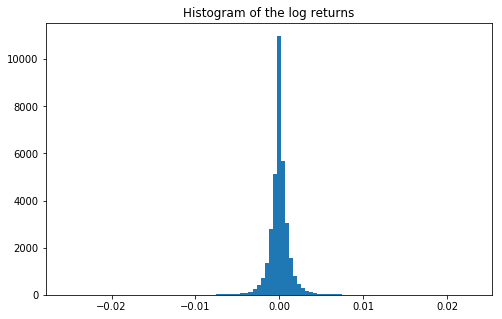

In [ ]:

weighted = average_prices
low = low_prices
high = high_prices

weighted = pd.DataFrame(weighted,index=trading_dates, columns=['average'])
low = pd.DataFrame(low,index=trading_dates, columns=['low'])
high = pd.DataFrame(high,index=trading_dates, columns=['high'])

def f(x):
    return np.log(x) - np.log(x.shift(1))
weighted_log_return = f(weighted)
low_log_return = f(low)
high_log_return = f(high)
plt.plot(trading_dates,  weighted_log_return, label='weighted_log_return')
plt.plot(trading_dates, low_log_return, label='low_log_return')
plt.plot(trading_dates, high_log_return, label='high_log_return')
plt.legend()
plt.title(poloniex_pair + ', log returns')
#ax=plt.axes()
#ax.xaxis.set_ticks([df.index.strftime("%H-%M")[0], df.index.strftime("%H-%M")[len(df.index)-1]])
#ax.xaxis.set_ticklabels([df.index.strftime("%H-%M")[0], df.index.strftime("%H-%M")[len(df.index)-1]])
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()

# histogram

##weighted_log_return2 = [incom for incom in weighted_log_return if str(incom) != 'nan']
# remove nan values
weighted_log_return2 = []
for j in range(len(weighted_log_return)):
    if str(weighted_log_return['average'][j]) != 'nan':
      weighted_log_return2.append(weighted_log_return['average'][j])
weighted_log_return2 = np.array(weighted_log_return2)

plt.hist(weighted_log_return2, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of the log returns")
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()

#Analysis of the log returns

We now transform the log returns by x -> x^c with c in (0.05, 0.1). We also plot the positive and negative values of this transform separately.

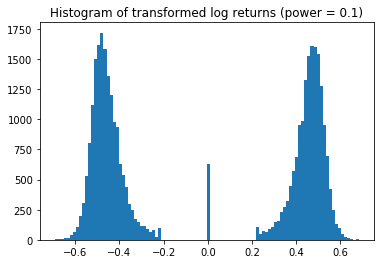

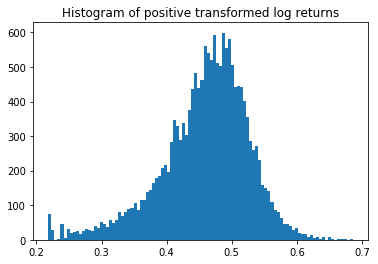

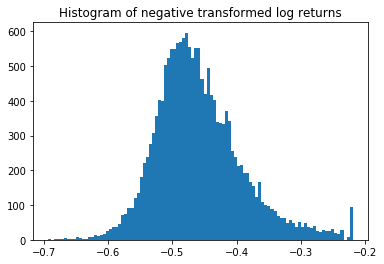

In [ ]:
power = 0.1

weighted_log_return3 = []
positive = []
negative = []
for j in weighted_log_return2:
    #if (j < 0.05) & (j>-0.05):
    val = np.power(np.abs(j),power)
    if j < 0:
        val = -val
    weighted_log_return3.append(val)
    if val > 0:
        positive.append(val)
    if val < 0:
        negative.append(val)
            
plt.hist(weighted_log_return3, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of transformed log returns (power = " + str(power) + ")")
plt.show()
plt.hist(positive, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of positive transformed log returns")
plt.show()
plt.hist(negative, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram of negative transformed log returns")
plt.show()


Next we try to find a distribution of the positive and negative values. The package scipy.stats offers several statistical methods and tests. We use the Kolmogorov-Smirnof one sided test ('stats.kstest'). For example, the following code determins whether 'positive' and 'negative' have a lognormal distribution.

In [ ]:
print(stats.kstest(positive, "lognorm", stats.lognorm.fit(positive)))
print(stats.kstest(negative, "lognorm", stats.lognorm.fit(negative)))

KstestResult(statistic=0.06718197350477917, pvalue=3.12460807606734e-66)
KstestResult(statistic=0.028326020943815977, pvalue=2.2576729640371666e-12)


We now use the Kolmogorov-Smirnof test for about 80 standard distributions and we determine the distribution giving the largest p value. (This may take some minutes. Please ignore the many warnings in the output cell.)

In [ ]:
power = 0.07

weighted_log_return3 = []
positive = []
negative = []
for j in weighted_log_return2:
    #if (j < 0.05) & (j>-0.05):
    val = np.power(np.abs(j),power)
   
    if j < 0:
        val = -val
    if val > 0:
        positive.append(val)
    if val < 0:
        negative.append(val)
            
p_max=0
cdf_max= 0

cdfs = [
    "norm",            #Normal (Gaussian)
    "alpha",           #Alpha
    "anglit",          #Anglit
    "arcsine",         #Arcsine
    "beta",            #Beta
    "betaprime",       #Beta Prime
    "bradford",        #Bradford
    "burr",            #Burr
    "cauchy",          #Cauchy
    "chi",             #Chi
    "chi2",            #Chi-squared
    "cosine",          #Cosine
    "dgamma",          #Double Gamma
    "dweibull",        #Double Weibull
    "erlang",          #Erlang
    "expon",           #Exponential
    "exponweib",       #Exponentiated Weibull
    "exponpow",        #Exponential Power
    "fatiguelife",     #Fatigue Life (Birnbaum-Sanders)
    "foldcauchy",      #Folded Cauchy
    "f",               #F (Snecdor F)
    "fisk",            #Fisk
    "foldnorm",        #Folded Normal
    "frechet_r",       #Frechet Right Sided, Extreme Value Type II
    "frechet_l",       #Frechet Left Sided, Weibull_max
    "gamma",           #Gamma
    "gausshyper",      #Gauss Hypergeometric
    "genexpon",        #Generalized Exponential
    "genextreme",      #Generalized Extreme Value
    "gengamma",        #Generalized gamma
    "genlogistic",     #Generalized Logistic
    "genpareto",       #Generalized Pareto
    "genhalflogistic", #Generalized Half Logistic
    "gilbrat",         #Gilbrat
    "gompertz",        #Gompertz (Truncated Gumbel)
    "gumbel_l",        #Left Sided Gumbel, etc.
    "gumbel_r",        #Right Sided Gumbel
    "halfcauchy",      #Half Cauchy
    "halflogistic",    #Half Logistic
    "halfnorm",        #Half Normal
    "hypsecant",       #Hyperbolic Secant
    "invgamma",        #Inverse Gamma
   # "invnorm",         #Inverse Normal
    "invweibull",      #Inverse Weibull
    "johnsonsb",       #Johnson SB
    "johnsonsu",       #Johnson SU
    "laplace",         #Laplace
    "logistic",        #Logistic
    "loggamma",        #Log-Gamma
    "loglaplace",      #Log-Laplace (Log Double Exponential)
    "lognorm",         #Log-Normal
    "lomax",           #Lomax (Pareto of the second kind)
    "maxwell",         #Maxwell
    "mielke",          #Mielke's Beta-Kappa
    "nakagami",        #Nakagami
    "ncx2",            #Non-central chi-squared
#    "ncf",             #Non-central F
    "nct",             #Non-central Student's T
    "pareto",          #Pareto
    "powerlaw",        #Power-function
    "powerlognorm",    #Power log normal
    "powernorm",       #Power normal
    "rdist",           #R distribution
    "reciprocal",      #Reciprocal
    "rayleigh",        #Rayleigh
    "rice",            #Rice
    "recipinvgauss",   #Reciprocal Inverse Gaussian
    "semicircular",    #Semicircular
    "t",               #Student's T
    "triang",          #Triangular
    "truncexpon",      #Truncated Exponential
    "truncnorm",       #Truncated Normal
    "tukeylambda",     #Tukey-Lambda
    "uniform",         #Uniform
    "vonmises",        #Von-Mises (Circular)
    "wald",            #Wald
    "weibull_min",     #Minimum Weibull (see Frechet)
    "weibull_max",     #Maximum Weibull (see Frechet)
    "wrapcauchy",      #Wrapped Cauchy
    "ksone",           #Kolmogorov-Smirnov one-sided (no stats)
    "kstwobign"]       #Kolmogorov-Smirnov two-sided test for Large N


#cdfs = [
 #   "johnsonsb",       #Johnson SB
  #  "burr",            #Burr
  
   # "genlogistic",     #Generalized Logistic

    #"johnsonsu",       #Johnson SU
    #"mielke"]       #Kolmogorov-Smirnov two-sided test for Large N


import warnings
warnings.filterwarnings("ignore")   

for cdf in cdfs:
    #fit our data set against every probability distribution
    parameters = eval("stats."+cdf+".fit(positive)")
 
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = stats.kstest(positive, cdf, args=parameters)
    if p > p_max:
        p_max = p
        cdf_max = cdf
        print("A new value for p_max: " + str(p_max) + ', distribution: ' + cdf)
    #pretty-print the results
    #print(cdf.ljust(16) + ("p: "+str(p)).ljust(25)+"D: "+str(D))
print("Maximal p value: " + str(p_max))
print("Distribution: " + cdf_max)

warnings.filterwarnings("default")

A new value for p_max: 3.5668429252063557e-84, distribution: norm
A new value for p_max: 0.21732029144967718, distribution: burr
A new value for p_max: 0.5876488085658015, distribution: genlogistic
Maximal p value: 0.5876488085658015
Distribution: genlogistic


Results for 'positive' with ETH vs. BTC for the time 01 2019 - 05 2019:


- power = 1; p value: 7.627359950311912e-12
distribution: lomax

- power = 0.5; p value: 0.005744691033422515
distribution: lognorm

- power = 1/3; p value: 0.013209130688052944
distribution: mielke

- power = 1/4; p value: 0.047773893818814236
distribution: burr

- power = 1/5; p value: 0.09090410920424132
distribution: mielke

- power = 0.1; p value: 0.27858648433921784
distribution: genlogistic

- power = 0.07;  0.7413930273917827 genlogistic  <----*best fit*

- power = 0.05; p value: 0.6645720365198221
distribution: genlogistic

- power = 0.01; p value: 0.10210450344990002
distribution: johnsonsu

- Taking the log instead of a power; p value: 0.09329808893611002
distribution: johnsonsu




Results for the corresponding 'negative':



- power = 0.07;   0.3673400970552034 johnsonsu

- power = 0.05;   0.4347618468551521 johnsonsu

- power = 0.04;  0.4647866259377428 johnsonsu

- power = 0.01;  0.5370943326838156 johnsonsu



Plot the fitted density:

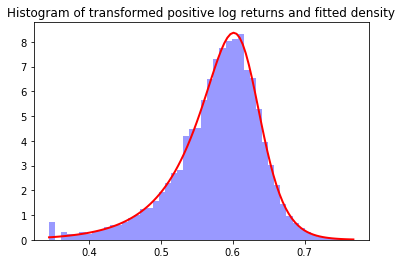

In [ ]:
parameters = eval("stats."+cdf_max+".fit(positive)")
parameters_string = ""
for j in range(len(parameters)-1):
  parameters_string = parameters_string + str(parameters[j]) + ","
parameters_string = parameters_string + str(parameters[len(parameters)-1])

# Plot the PDF
xmin = min(positive)
xmax = max(positive)
x = np.linspace(xmin, xmax, 100)
p = eval("stats."+cdf_max+".pdf(x, "+parameters_string+")")

pos = np.array(positive)
plt.hist(pos, bins=50, density=True, alpha=0.4, color='b')
plt.plot(x, p, 'k', linewidth=2, color='r')
plt.title("Histogram of transformed positive log returns and fitted density")
plt.show()



We can also fix one distribution and determine the best value for 'power':

In [ ]:
p_max = 0
power_found = 0
for j in range(100):
    power = 0.01+j/100.0
    weighted_log_return4 = []
    positive = []
    negative = []
    for j in weighted_log_return2:
        #if (j < 0.07) & (j>-0.07):
        val = np.power(np.abs(j),power)
        if j < 0:
            val = -val
        weighted_log_return4.append(val)
        if val > 0:
            positive.append(val)
        if val < 0:
            negative.append(val)
    #s=stats.kstest(positive, "lognorm", stats.lognorm.fit(positive)) 
    parameters = eval("stats."+"genlogistic"+".fit(positive)")
 
    #Applying the Kolmogorov-Smirnof one sided test
    D, p = stats.kstest(positive, "genlogistic", args=parameters)
    if p > p_max:
        p_max = p
        power_found = power
        print("new p_max:" + str(p_max))
        
print("power: " + str(power_found))
print("p value: " + str(p_max))



new p_max:0.08330237927165195
new p_max:0.18095481103898994
new p_max:0.3432035614320998
new p_max:0.5697592414628938
new p_max:0.7147127819484012
new p_max:0.760797598480556
power: 0.060000000000000005
p value: 0.760797598480556
